# Randomized matrix multiplication
### Filitov Mikhail

### Problem:
 Numerical linear algebra (NLA) is a well-established and important part of computer science.
Some of the basic problems in this area include multiplying matrices, solving linear systems,
computing eigenvalues and eigenvectors, and solving linear least-squares problems. Historically, the NLA community has focused on developing highly accurate deterministic methods
that require as few floating-point operations as possible. Unfortunately, contemporary appllcations can strain standard NLA methods because problems have continued to become larger.
Furthermore, on modern computer architectures, computational costs depend heavily on communication and other resources that the standard algorithms do not manage very well.


Performing large calculations is almost always long and expensive. Sometimes there are situations where the speed of the algorithm is more important than the 100% accuracy. Here is such algorithm.

Full algorithm is in an article, but the idea is to make the probability distribution over the matrix, then multiplythe random column and row, and then multiply by the corresponding coefficients from the distribution.

$$
p_j = \frac{||b_{:j}||^2 + ||c_{j:}||^2}{||B||_{F}^2 + ||C||_{F}^2}
\qquad for \: j = 1, 2, 3, ... N
$$

The expectation of that multiplication would be exactly BC.

$$
\mathbb{E} \: R = \sum_{j=1}^{N} \frac{1}{p_j} b_{:j} c_{j:} p_{j} =
\sum_{j=1}^{N} b_{:j} c_{j:} = BC
$$

---

To generate random matrix we'll use sklearn.datasets.make_low_rank_matrix, which guaranties matrix of fixed effective rank.

rows/cols - number of columns and rowl we will multiply using approximate algorithm.

In [33]:
from sklearn.datasets import make_low_rank_matrix
from numpy import linalg as LA
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
from tqdm import tqdm
import pandas as pd
warnings.filterwarnings('ignore')

In [8]:
def rows_norms_squares_n(matrix):
    return np.sum(np.abs(matrix)**2,axis=1)


def cols_norms_squares_n(matrix):
    return np.sum(np.abs(matrix)**2,axis=0)

In [20]:
def distribution_n(matrix_A, matrix_B, num):
    rows_norms_B = rows_norms_squares_n(matrix_B[:num])
    cols_norms_A = cols_norms_squares_n(matrix_A[:, :num])
    denom = LA.norm(matrix_A, 'fro') ** 2 + LA.norm(matrix_B, 'fro') ** 2
    return (rows_norms_B + cols_norms_A) / denom

def mult_matrix_n(matrix_A, matrix_B, num):
    dist = distribution_n(matrix_A, matrix_B, 2 * num)
    res = np.dot(np.matrix(matrix_A[:, 0]).T, np.matrix(matrix_B[0])) / dist[0]
    for i in range(num):
        res += np.dot(np.matrix(matrix_A[:, num + i]).T, np.matrix(matrix_B[num + i])) / dist[num + i]
    res /= num + 1
    return res

First of all lets find out the number of rows/columns we need to multiplicate to get good result. 
We will increase the number of rows/columns until the difference cease to change greatly. Use matrix of size 1000 with effective rank = 10.

In [23]:
norms = []
sizes = []

i = 10
while i < 500:
    sizes.append(i)
    a = np.array(make_low_rank_matrix(1000, 1000, 10))
    b = np.array(make_low_rank_matrix(1000, 1000, 10))
    res = mult_matrix_n(a, b, i)
    mul = np.matmul(a, b)
    norms.append(LA.norm(mul - res, 'fro'))
    i += 10

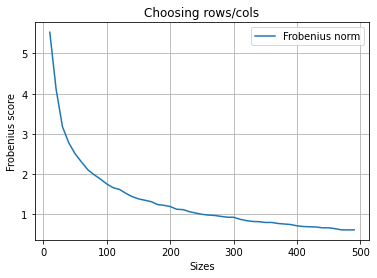

In [24]:
plt.title(r'Choosing rows/cols')
plt.plot(sizes,norms, label=u"Frobenius norm")
plt.legend()
plt.grid()
plt.xlabel('Sizes')
plt.ylabel('Frobenius score');

The result is quite predictable. The more cols/rows we take, the less Frobenius score we get. 3-4 is pretty normal, so rows/cols size will be 10, it's easier to multiplicate.

---

The other interesting experiment is why do we need low-rank matrices. Try to multiplicate matrices with normal rank. Size of cols/rows = 10

In [25]:
norms2 = []
rank_size = []

i = 10
while i < 500:
    rank_size.append(i)
    a = np.array(make_low_rank_matrix(1000, 1000, i))
    b = np.array(make_low_rank_matrix(1000, 1000, i))
    res = mult_matrix_n(a, b, 10)
    mul = np.matmul(a, b)
    norms2.append(LA.norm(mul - res, 'fro'))
    i += 10

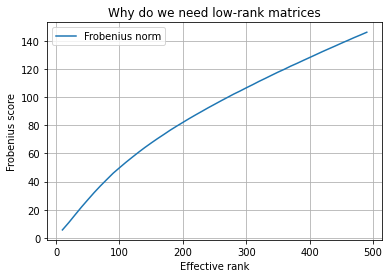

In [26]:
plt.title(r'Why do we need low-rank matrices')
plt.plot(rank_size, norms2, label=u"Frobenius norm")
plt.legend()
plt.grid()
plt.xlabel('Effective rank')
plt.ylabel('Frobenius score');

This line grows fast, this is the reason, why this algorithm is suitable only for low-rank matrices.

---

Compare computation speed (our matrices have rank 10):

In [27]:
def matmult(matrix_A, matrix_B):
    result = [[0 for e in range(len(matrix_A))] for e in range(len(matrix_A))]
    for i in range(len(matrix_A)):
   # iterate through columns of Y
       for j in range(len(matrix_B[0])):
       # iterate through rows of Y
           for k in range(len(matrix_B)):
               result[i][j] += matrix_A[i][k] * matrix_B[k][j]
    return result

In [42]:
matrix_size = []
time_matrix_multiplication = []
time_matrix_fast_multiplication = []
time_randomized_multiplication = []
norms = []

i = 20
while i < 300:
    matrix_size.append(i)
    a = np.array(make_low_rank_matrix(i, i, 10))
    b = np.array(make_low_rank_matrix(i, i, 10))
    
    df = pd.DataFrame(data=a)
    df.to_csv('mat/a'+str(i)+'.csv', sep=' ', header=False, index=False)
    df = pd.DataFrame(data=b)
    df.to_csv('mat/b'+str(i)+'.csv', sep=' ', header=False, index=False)
    
    start = time.time()
    res = mult_matrix_n(a, b, 10)
    time_randomized_multiplication.append(time.time() - start)
    
    start = time.time()
    mul = matmult(a, b)
    time_matrix_multiplication.append(time.time() - start)
    
    start = time.time()
    mul = np.dot(a, b)
    time_matrix_fast_multiplication.append(time.time() - start)
    
    norms.append(LA.norm(mul - res, 'fro'))
    i += 10

In [60]:
# load c++ results
cpp_res = pd.read_csv('result.csv', sep=' ')

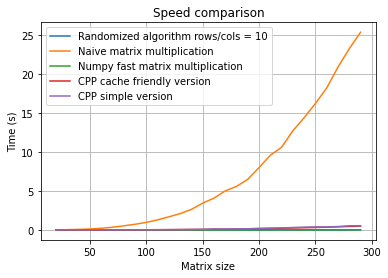

In [59]:
f, p = plt.subplots(1)

p.plot(matrix_size, time_randomized_multiplication, label=u"Randomized algorithm rows/cols = 10")
p.plot(matrix_size, time_matrix_multiplication, label=u"Naive matrix multiplication")
p.plot(matrix_size, time_matrix_fast_multiplication, label=u"Numpy fast matrix multiplication")
p.plot(matrix_size, cpp_res['cache'].tolist(), label=u"CPP cache friendly version")
p.plot(matrix_size, cpp_res['nocache'].tolist(), label=u"CPP simple version")
p.set_title(u"Speed comparison")
p.set_xlabel(u"Matrix size")
p.set_ylabel(u"Time (s)")
p.grid()
p.legend()

as we can see naive matrix multiplication implemented in python is extremely slow. Try other methods on larger sets.

In [62]:
matrix_size = []
time_matrix_multiplication = []
time_matrix_fast_multiplication = []
time_randomized_multiplication = []
norms = []

i = 300
while i < 1000:
    matrix_size.append(i)
    a = np.array(make_low_rank_matrix(i, i, 10))
    b = np.array(make_low_rank_matrix(i, i, 10))
    
    df = pd.DataFrame(data=a)
    df.to_csv('mat/a'+str(i)+'.csv', sep=' ', header=False, index=False)
    df = pd.DataFrame(data=b)
    df.to_csv('mat/b'+str(i)+'.csv', sep=' ', header=False, index=False)
    
    start = time.time()
    res = mult_matrix_n(a, b, 10)
    time_randomized_multiplication.append(time.time() - start)

    
    start = time.time()
    mul = np.dot(a, b)
    time_matrix_fast_multiplication.append(time.time() - start)
    
    norms.append(LA.norm(mul - res, 'fro'))
    i += 50

In [64]:
# load c++ results
cpp_res = pd.read_csv('result.csv', sep=' ')

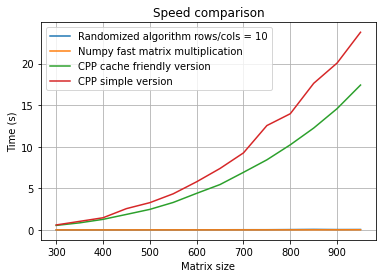

In [65]:
f, p = plt.subplots(1)

p.plot(matrix_size, time_randomized_multiplication, label=u"Randomized algorithm rows/cols = 10")
p.plot(matrix_size, time_matrix_fast_multiplication, label=u"Numpy fast matrix multiplication")
p.plot(matrix_size, cpp_res['cache'].tolist(), label=u"CPP cache friendly version")
p.plot(matrix_size, cpp_res['nocache'].tolist(), label=u"CPP simple version")
p.set_title(u"Speed comparison")
p.set_xlabel(u"Matrix size")
p.set_ylabel(u"Time (s)")
p.grid()
p.legend()

On these datasets we can see that both c++ naive implementations are too slow. Next round.

In [71]:
matrix_size = []
time_matrix_multiplication = []
time_matrix_fast_multiplication = []
time_randomized_multiplication = []
norms = []

i = 1000
while i < 11000:
    print(i)
    matrix_size.append(i)
    a = np.array(make_low_rank_matrix(i, i, 10))
    b = np.array(make_low_rank_matrix(i, i, 10))
    
    start = time.time()
    res = mult_matrix_n(a, b, 10)
    time_randomized_multiplication.append(time.time() - start)

    start = time.time()
    mul = np.dot(a, b)
    time_matrix_fast_multiplication.append(time.time() - start)
    
    norms.append(LA.norm(mul - res, 'fro'))
    i += 1000

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


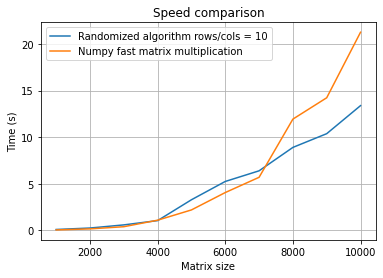

In [73]:
f, p = plt.subplots(1)

p.plot(matrix_size, time_randomized_multiplication, label=u"Randomized algorithm rows/cols = 10")
p.plot(matrix_size, time_matrix_fast_multiplication, label=u"Numpy fast matrix multiplication")
p.set_title(u"Speed comparison")
p.set_xlabel(u"Matrix size")
p.set_ylabel(u"Time (s)")
p.grid()
p.legend()

we can see that its' hard to compete with numpy. But on large matrices randomized algorithm shows better results.

Conclusion: this algorithm works faster, than regular multiplication, it's complexity is $O(N(d_1 + d_2)$) to compute probabilities and $O(N\times d_1 \times d_2)$ to multiply, where $d_1$, $d_2$ - are number of rows/cols we multiplicate (N is substantially larger than the outer dimensions $d_1$ and
$d_2$), while the largest known lower bound for matrix-multiplication complexity is $\Omega(n^2 log(n))$.
Also this algorithm shows good results on low-rank matrices, and we can multiply small amount of rows/cols (about 10, when data size is 1000).

__Used literature__:

1. An Introduction to Matrix Concentration Inequalities, Joel A. Tropp 24 December 2014 FnTML Draft, Revised